In [27]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Mengimpor library yang diperlukan
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Mengecek isi direktori Google Drive
!ls /content/drive/
# Menetapkan path ke dataset
dataset_path = '/content/drive/MyDrive/dataset_tomat'

MyDrive


In [30]:
# Path ke dataset di Google Drive
sdir = '/content/drive/MyDrive/dataset_tomat/train'

filepaths = []
labels = []
classlist = os.listdir(sdir)

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths  \
0  /content/drive/MyDrive/dataset_tomat/train/Tom...   
1  /content/drive/MyDrive/dataset_tomat/train/Tom...   
2  /content/drive/MyDrive/dataset_tomat/train/Tom...   
3  /content/drive/MyDrive/dataset_tomat/train/Tom...   
4  /content/drive/MyDrive/dataset_tomat/train/Tom...   

                                          labels  
0  Tomato___Spider_mites Two-spotted_spider_mite  
1  Tomato___Spider_mites Two-spotted_spider_mite  
2  Tomato___Spider_mites Two-spotted_spider_mite  
3  Tomato___Spider_mites Two-spotted_spider_mite  
4  Tomato___Spider_mites Two-spotted_spider_mite  
labels
Tomato___Spider_mites Two-spotted_spider_mite    1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___Leaf_Mold                               1000
Tomato___Bacterial_spot                          1000
Tomato___healthy                                 1000
Tomato___Early_blight     

In [31]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [32]:
data_dir = '/content/drive/MyDrive/dataset_tomat/train'
df = loading_the_data(data_dir)

df

filepaths  \
0     /content/drive/MyDrive/dataset_tomat/train/Tom...   
1     /content/drive/MyDrive/dataset_tomat/train/Tom...   
2     /content/drive/MyDrive/dataset_tomat/train/Tom...   
3     /content/drive/MyDrive/dataset_tomat/train/Tom...   
4     /content/drive/MyDrive/dataset_tomat/train/Tom...   
...                                                 ...   
9995  /content/drive/MyDrive/dataset_tomat/train/Tom...   
9996  /content/drive/MyDrive/dataset_tomat/train/Tom...   
9997  /content/drive/MyDrive/dataset_tomat/train/Tom...   
9998  /content/drive/MyDrive/dataset_tomat/train/Tom...   
9999  /content/drive/MyDrive/dataset_tomat/train/Tom...   

                                             labels  
0     Tomato___Spider_mites Two-spotted_spider_mite  
1     Tomato___Spider_mites Two-spotted_spider_mite  
2     Tomato___Spider_mites Two-spotted_spider_mite  
3     Tomato___Spider_mites Two-spotted_spider_mite  
4     Tomato___Spider_mites Two-spotted_spider_mite  
...                                             ...  
9995                           Tomato___Late_blight  
9996                           Tomato___Late_blight  
9997                           Tomato___Late_blight  
9998                           Tomato___Late_blight  
9999                           Tomato___Late_blight  

[10000 rows x 2 columns]

In [33]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Spider_mites Two-spotted_spider_mite    1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___Leaf_Mold                               1000
Tomato___Bacterial_spot                          1000
Tomato___healthy                                 1000
Tomato___Early_blight                            1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___Target_Spot                             1000
Tomato___Late_blight                             1000
Name: count, dtype: int64

In [34]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

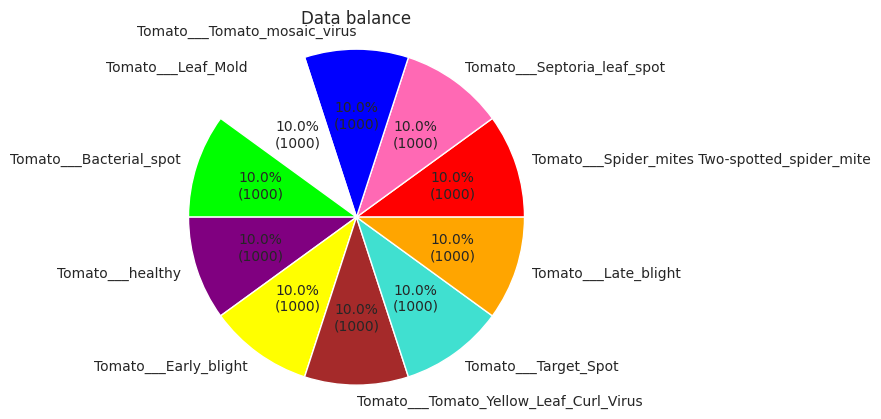

In [35]:
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#FF0000", "#FF69B4", "#0000FF", "#FFFFFF", "#00FF00", "#800080", "#FFFF00", "#A52A2A", "#40E0D0", "#FFA500"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

In [36]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [37]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [38]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred

In [39]:
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45, fontsize=8)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [40]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [41]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [42]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [43]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


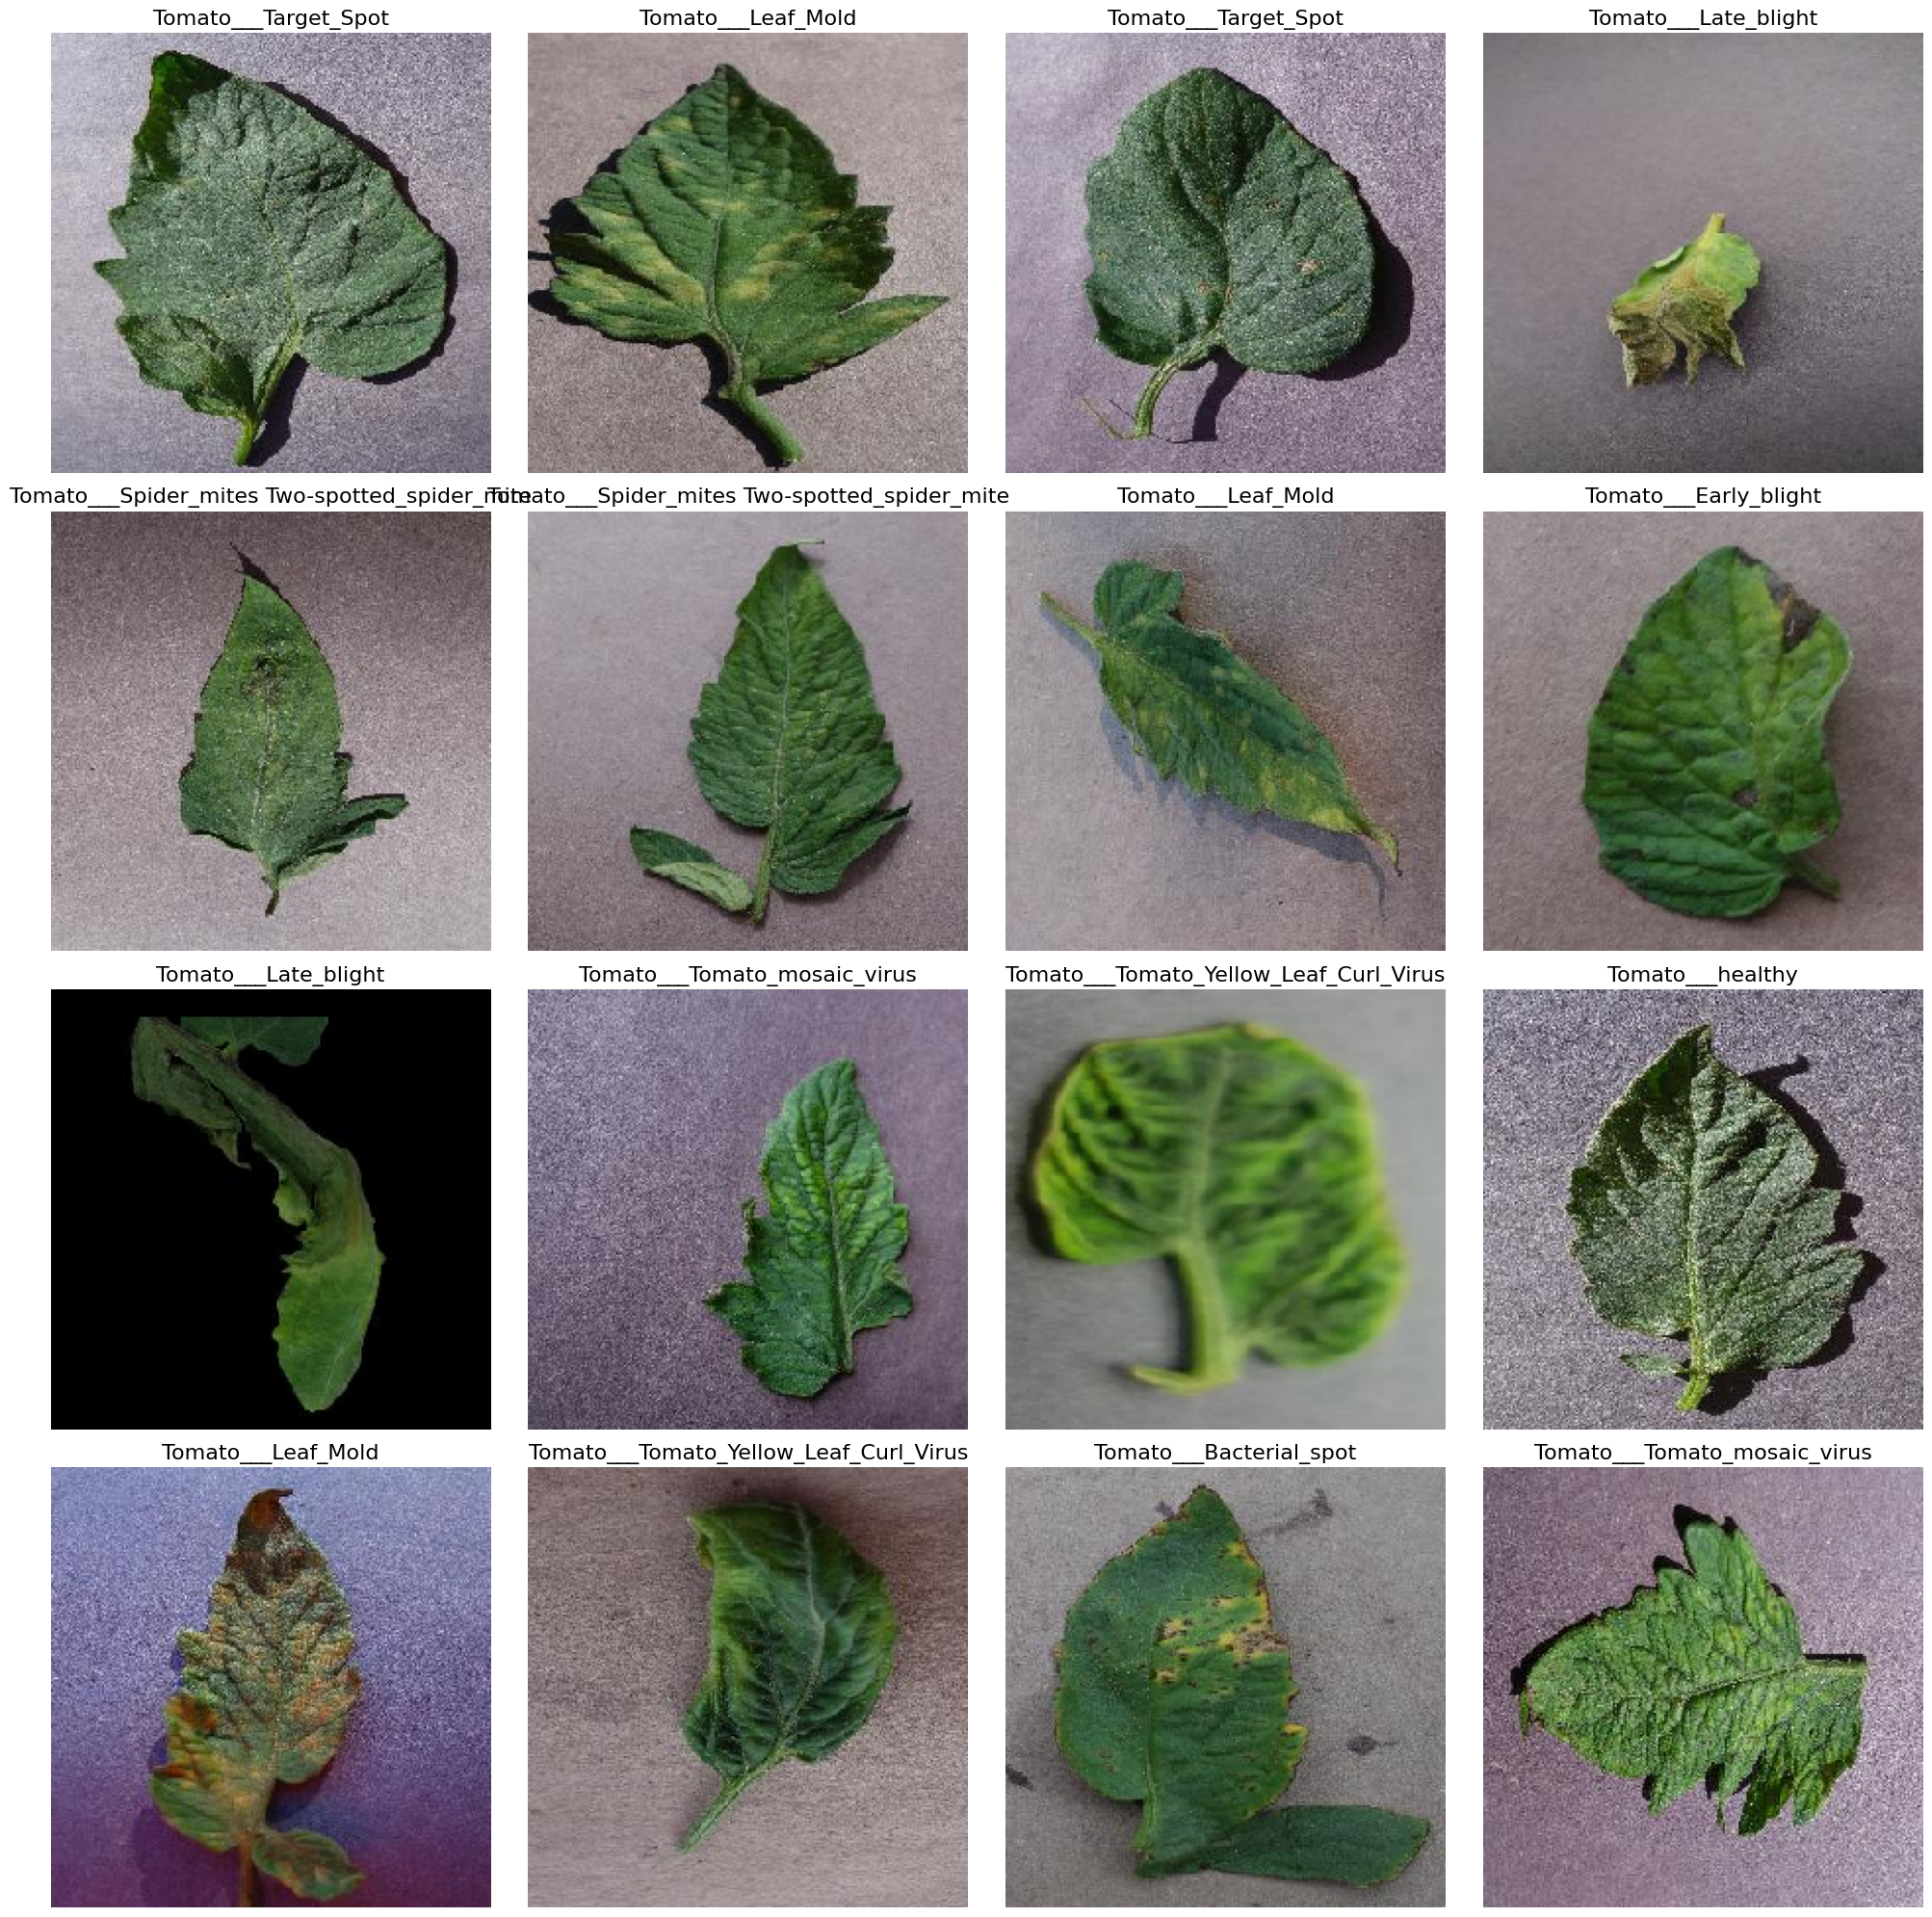

In [44]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [45]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))

In [46]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation


EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

In [47]:
for layer in EfficientNetB3_model.layers:
    print(layer.name, layer.trainable)

input_2 True
rescaling_2 True
normalization_1 True
rescaling_3 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block1b_dwconv True
block1b_bn True
block1b_activation True
block1b_se_squeeze True
block1b_se_reshape True
block1b_se_reduce True
block1b_se_expand True
block1b_se_excite True
block1b_project_conv True
block1b_project_bn True
block1b_drop True
block1b_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn Tr

In [48]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [49]:
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs=epochs, verbose=1,
                                                  validation_data=valid_gen, shuffle=False,
                                                  callbacks=[early_stopping])

Epoch 1/20
500/500 [==============================] - 216s 278ms/step - loss: 2.0989 - accuracy: 0.3015 - val_loss: 2.2055 - val_accuracy: 0.2240
Epoch 2/20
500/500 [==============================] - 137s 274ms/step - loss: 1.3029 - accuracy: 0.5642 - val_loss: 1.1302 - val_accuracy: 0.6620
Epoch 3/20
500/500 [==============================] - 137s 275ms/step - loss: 0.9429 - accuracy: 0.7225 - val_loss: 1.0870 - val_accuracy: 0.6940
Epoch 4/20
500/500 [==============================] - 138s 275ms/step - loss: 0.7342 - accuracy: 0.8023 - val_loss: 1.0291 - val_accuracy: 0.7030
Epoch 5/20
500/500 [==============================] - 138s 275ms/step - loss: 0.5925 - accuracy: 0.8514 - val_loss: 0.8244 - val_accuracy: 0.7800
Epoch 6/20
500/500 [==============================] - 138s 276ms/step - loss: 0.4992 - accuracy: 0.8863 - val_loss: 0.4978 - val_accuracy: 0.8860
Epoch 7/20
500/500 [==============================] - 137s 274ms/step - loss: 0.4206 - accuracy: 0.9099 - val_loss: 0.5630 -

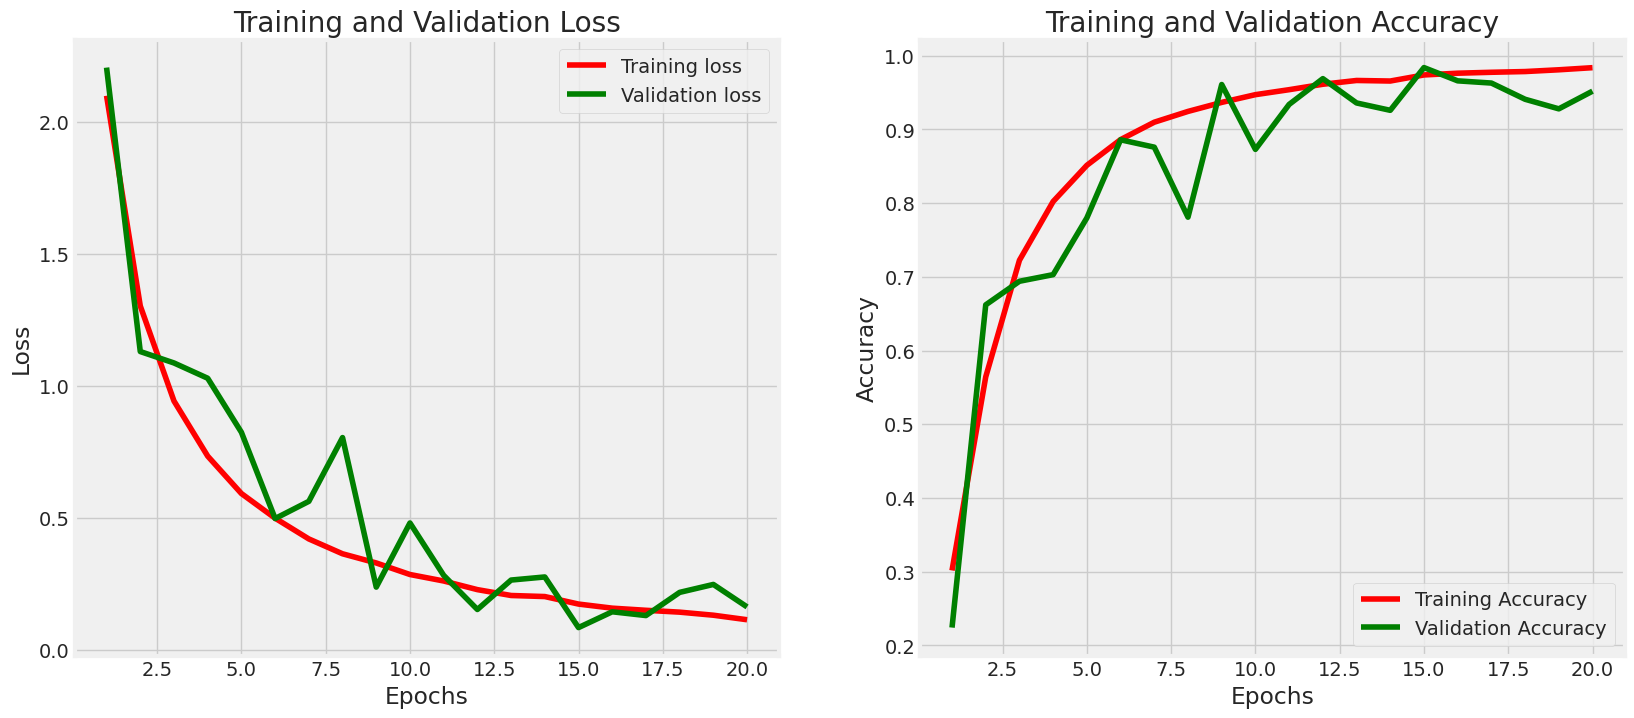

In [52]:
model_performance(EfficientNetB3_history, epochs)

In [53]:
model_evaluation(EfficientNetB3_model)

63/63 [==============================] - 300s 5s/step - loss: 0.1918 - accuracy: 0.9480
Train Loss:  0.07613872736692429
Train Accuracy:  0.9829999804496765
--------------------
Validation Loss:  0.16329267621040344
Validation Accuracy:  0.9520000219345093
--------------------
Test Loss:  0.19180957973003387
Test Accuracy:  0.9480000138282776


63/63 [==============================] - 7s 75ms/step


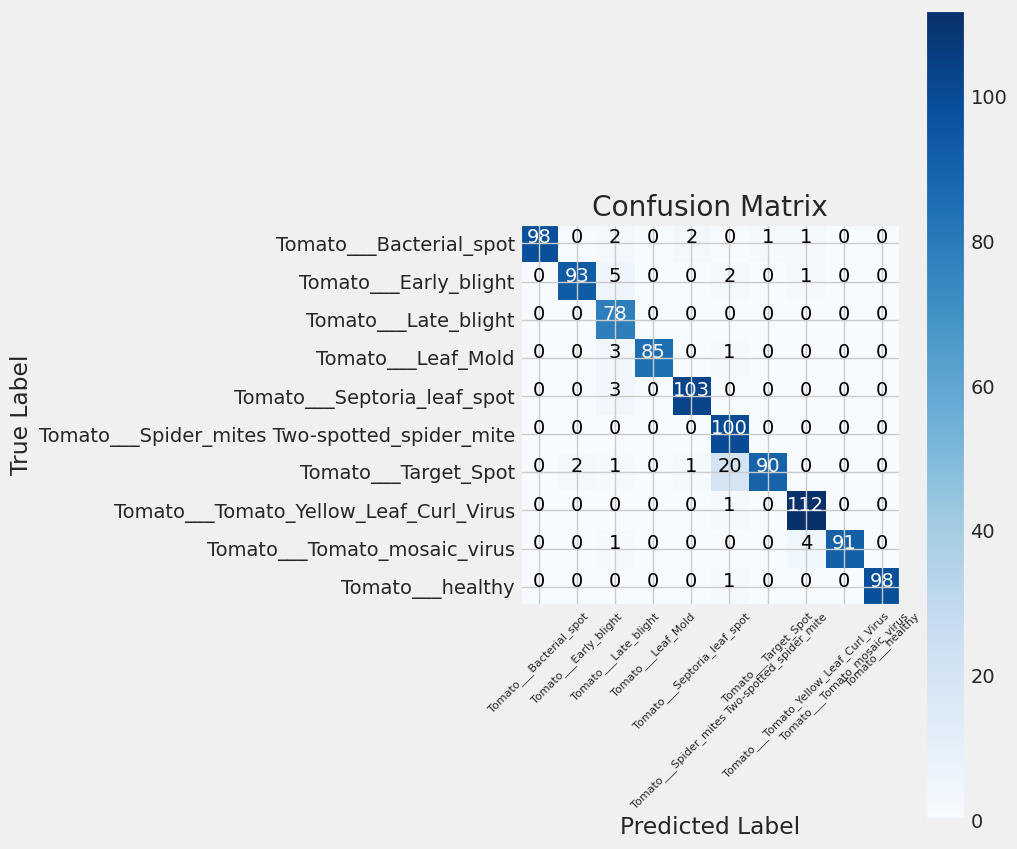

In [54]:
y_pred = get_pred(EfficientNetB3_model, test_gen)

plot_confusion_matrix(test_gen, y_pred)

63/63 [==============================] - 5s 86ms/step
Classification Report:
                                                precision    recall  f1-score   support

                      Tomato___Bacterial_spot       1.00      0.94      0.97       104
                        Tomato___Early_blight       0.98      0.92      0.95       101
                         Tomato___Late_blight       0.84      1.00      0.91        78
                           Tomato___Leaf_Mold       1.00      0.96      0.98        89
                  Tomato___Septoria_leaf_spot       0.97      0.97      0.97       106
Tomato___Spider_mites Two-spotted_spider_mite       0.80      1.00      0.89       100
                         Tomato___Target_Spot       0.99      0.79      0.88       114
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.95      0.99      0.97       113
                 Tomato___Tomato_mosaic_virus       1.00      0.95      0.97        96
                             Tomato___healthy      

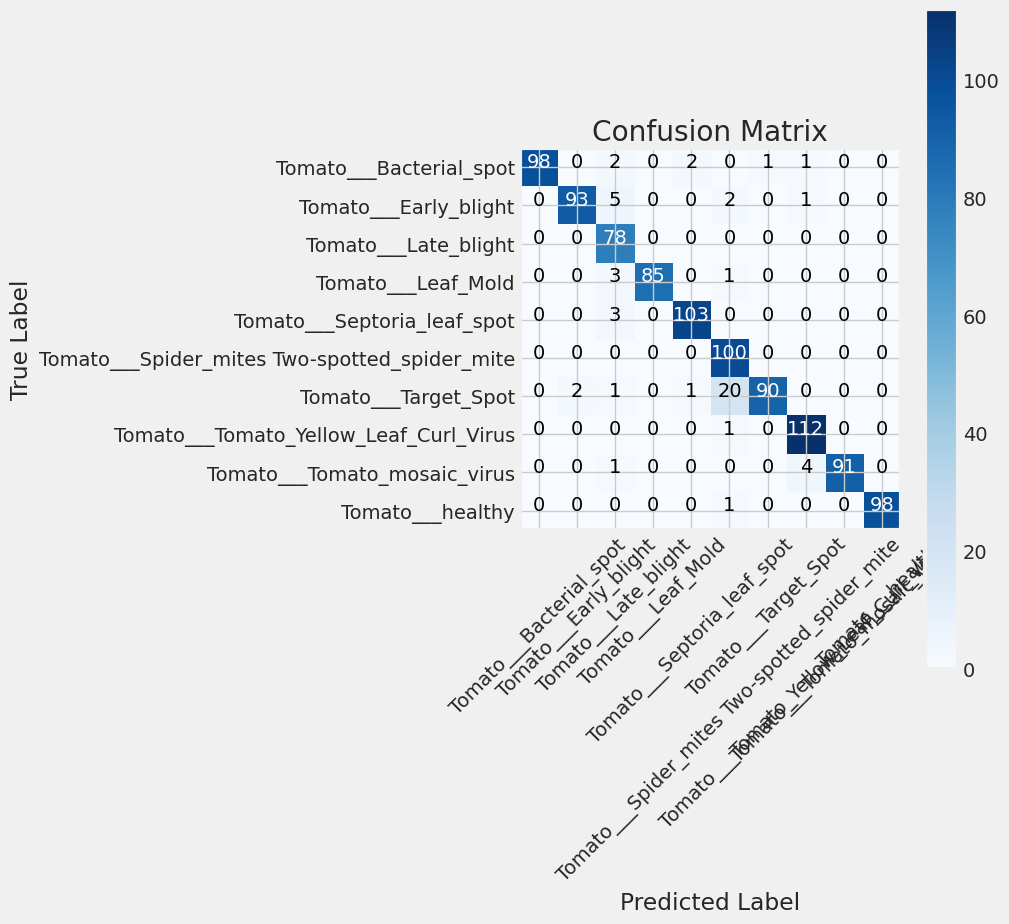

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error
import itertools

# Function to evaluate model and get metrics
def evaluate_model(model, test_gen):
    # Get true labels and predictions
    y_true = test_gen.classes
    y_pred = get_pred(model, test_gen)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute evaluation metrics
    report = classification_report(y_true, y_pred, target_names=classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print("Classification Report:\n", report)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(cm, classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate the model and print metrics
evaluate_model(EfficientNetB3_model, test_gen)

In [56]:
# Save the model weights
EfficientNetB3_model.save_weights('model_tomato.weights.h5')
print('Saved trained model weights as model_tomato.weights.h5')

# Export model architecture to JSON
model_json = EfficientNetB3_model.to_json()
with open('model_tomato.json', 'w') as json_file:
    json_file.write(model_json)
print('Saved model architecture as model_tomato.json')

# Save the full model in H5 format
EfficientNetB3_model.save('model_tomato.h5')
print('Saved full model as model_tomato.h5')


# Convert and save the model to TFLite format
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(EfficientNetB3_model)
    tflite_model = converter.convert()
    with open('model_tomato.tflite', 'wb') as tflite_file:
        tflite_file.write(tflite_model)
    print('Saved model as model_tomato.tflite')
except Exception as e:
    print(f'Failed to convert to TFLite: {e}')

Saved trained model weights as model_tomato.weights.h5
Saved model architecture as model_tomato.json
Saved full model as model_tomato.h5
Saved model as model_tomato.tflite
